# Kernels Calculation
The kernels are estimations of the direction of the main source of larvae (see figure 1). To achieve this, the following steps are necessary:

1. Divide all the possible connections for each sink into 36 possible directions of connections at 10-degree angles, starting from 0 degrees.

2. Calculate the bandwidth (DS) of the kernel, which is determined by the degrees of the location of the main source reefs contributing to the connectivity. This is done by selecting the two main sources of connectivity and adding more adjacent sectors until at least 80% of the total connectivity arrives at that sink reef.

3. Calculate the central direction of the connection (S), which is the central angle for each kernel (central value of the bandwidth).

4. Calculate the distance between the sink and source reef (R), which is a weighted average of the relative contribution of each source reef.

More details on the calculation of these kernels are explained in the code.




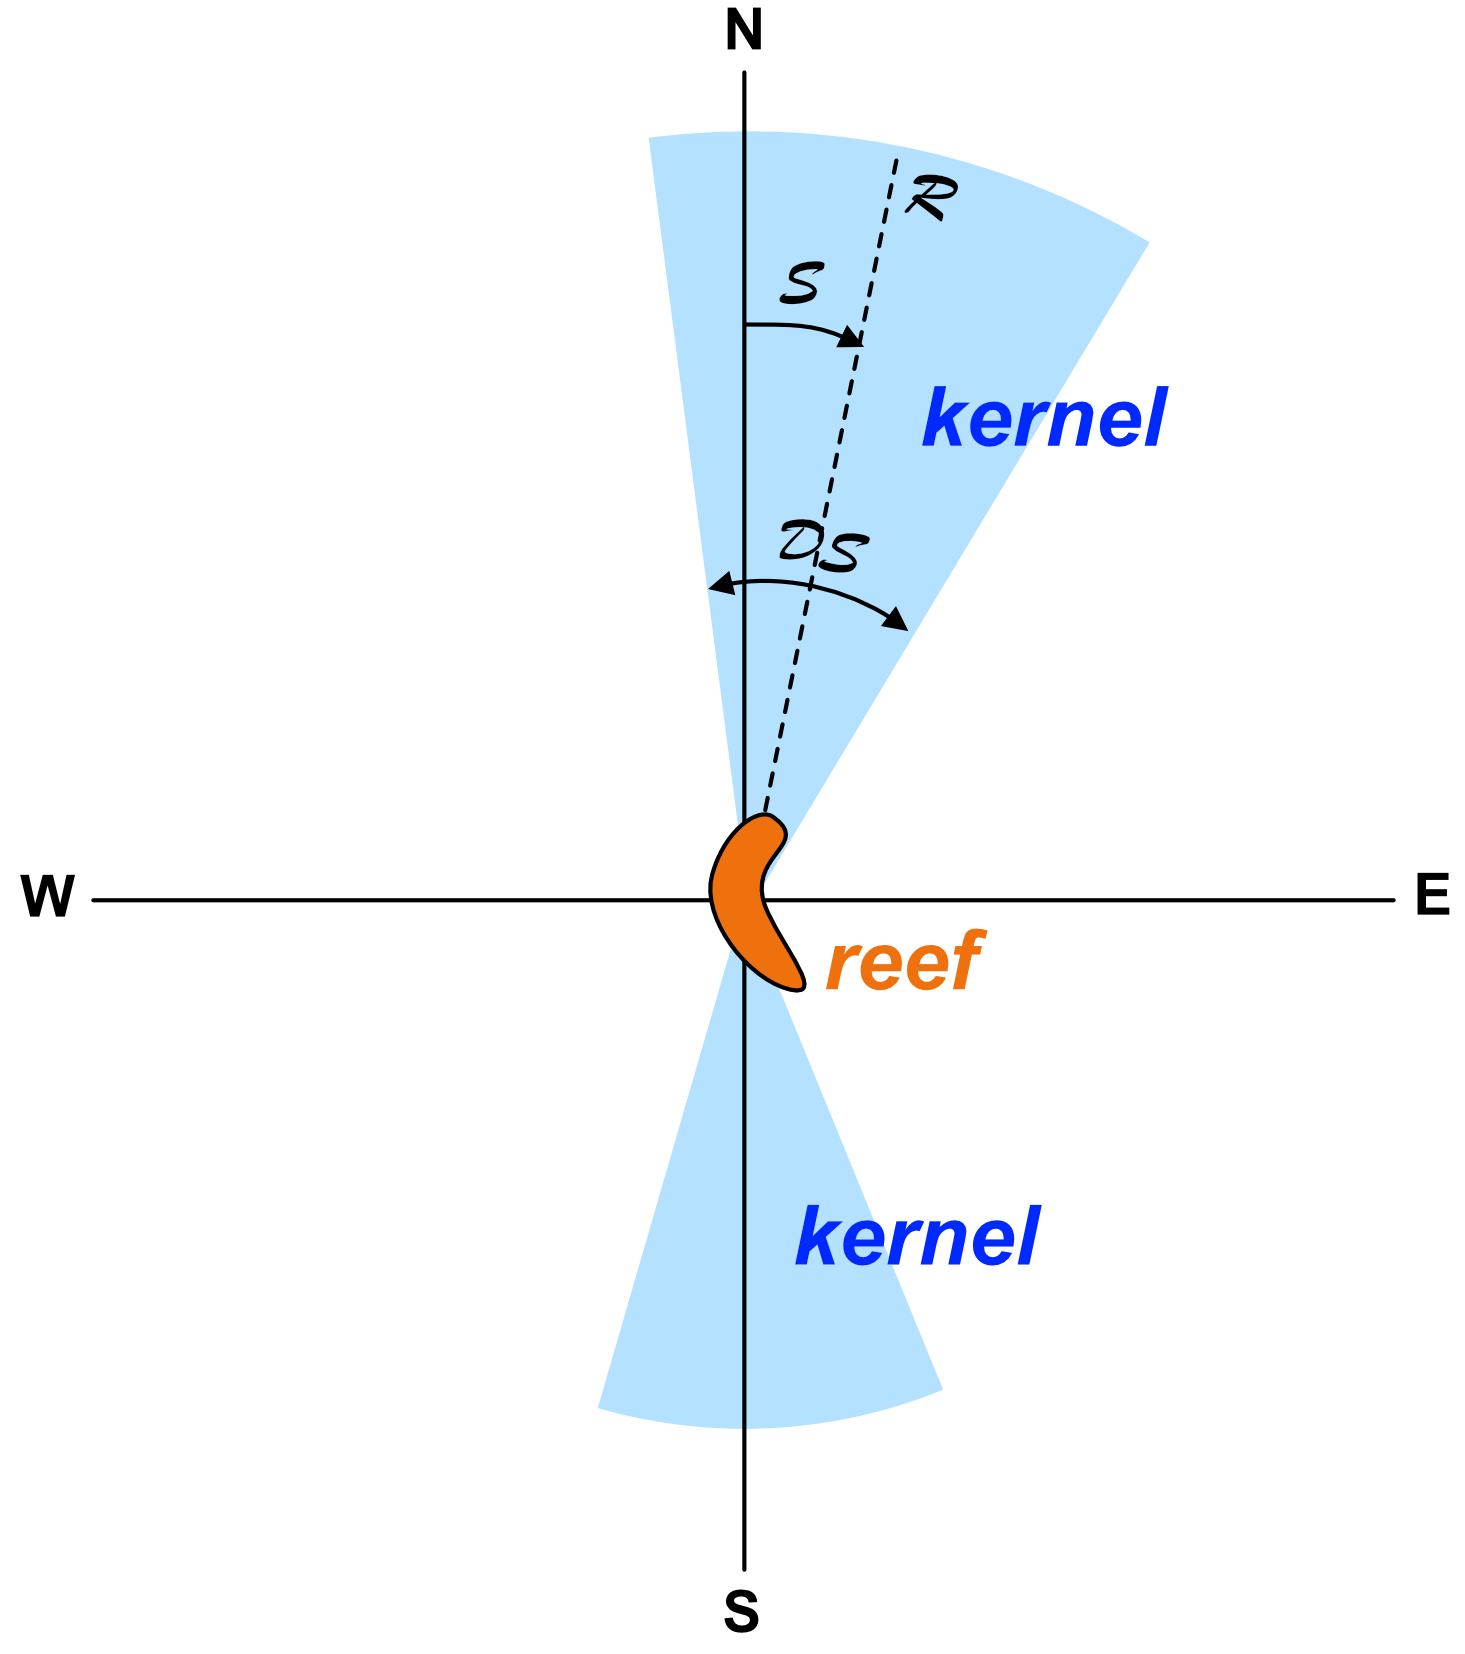

Figure 1: Schematic of the connectivity Kernel calculations

## Dependencies

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import math
import glob

## Functions Description:
The following functions constitute a set of operations related to connectivity analysis for coral reefs. These functions are designed to process data from shapefiles, distance matrices, and angle matrices to calculate various connectivity parameters. They provide essential functionalities such as selecting source and sink locations, ordering data based on a shapefile, calculating connectivity by sectors, and identifying top sectors with the highest connectivity.

### Suggestion for Optimization (to-do):

Given the complexity and number of functions involved in connectivity analysis, it is recommended to save these functions in a separate file or library for optimization and reusability. By doing so, other scripts or projects can easily import and utilize these functions without duplicating code. Organizing these functions in a separate module will also enhance code maintenance and allow for future updates and improvements. Additionally, by centralizing these functions in a dedicated library, it becomes possible to streamline the process of making enhancements, bug fixes, and performance optimizations.


In [ ]:
# Load input files for connectivity, angle, and shape information
def get_centroids(shapefile):
    """"
    This function reads a shapefile using geopandas and extracts the centroids of each polygon in the shapefile. It also generates a reef order based on the 'FID' (Feature ID) attribute in the shapefile.
    Input:
        shapefile (string): The file path of the shapefile to be processed.
    Output:
        reef_centroids (list of Point): A list containing the centroid locations of each polygon.
        reef_order (list of int): A list containing the ordered indices of reefs corresponding to the shapefile.
    """"
    data_shape = gpd.read_file(shapefile)
    num_sites = data_shape.shape[0]
    reef_centroids = []
    reef_order = []
    # getting the centroid's location
    for site in range(0, num_sites):
        # release reef
        value_index = list(data_shape.loc[data_shape['FID'] == site].index)
        value_index = int("".join(map(str, value_index)))
        reef_order.append(value_index)
        polygon = data_shape['geometry'][value_index]
        reef_centroids.append(polygon.centroid)
    return reef_centroids, reef_order


def reef_ordering(distance_matrix, angle_matrix, reef_order):
    """"
    This function reorders the distance and angle matrices based on the reef order obtained from the shapefile.
    Input:
        distance_matrix (2D numpy array): The distance matrix between reefs.
        angle_matrix (2D numpy array): The angle matrix between reefs.
        reef_order (list of int): The ordered indices of reefs based on the shapefile.
    Output:
        distance_matrix_ordered (2D numpy array): The distance matrix reordered according to the reef order.
        angle_matrix_ordered (2D numpy array): The angle matrix reordered according to the reef order.
    """"
    idx = np.empty_like(reef_order)
    idx[reef_order] = np.arange(len(reef_order))
    distance_matrix_ordered = distance_matrix[:, idx][idx]
    angle_matrix_ordered = angle_matrix[:, idx][idx]
    return distance_matrix_ordered, angle_matrix_ordered


def select_source_locations(connectivity_matrix, angle_matrix, distance_matrix, sink_area):
    """"
    This function selects source locations that contribute to recruitment in a given sink area based on the connectivity, angle, and distance matrices.
    Input:
        connectivity_matrix (2D numpy array): The connectivity matrix between reefs.
        angle_matrix (2D numpy array): The angle matrix between reefs.
        distance_matrix (2D numpy array): The distance matrix between reefs.
        sink_area (int): The index of the sink area.
    Output:
        source_connection (1D numpy array): The connectivity values from source reefs to the sink area.
        source_angles (1D numpy array): The angles between source reefs and the sink area.
        source_distance (1D numpy array): The distances between source reefs and the sink area.
    """"
    source_connection = connectivity_matrix[:, sink_area]
    source_angles = angle_matrix[:, sink_area]
    source_distance = distance_matrix[:, sink_area]
    return source_connection, source_angles, source_distance


def select_sink_locations(connectivity_matrix, angle_matrix, distance_matrix, source_area):
    """"
    This function selects sink locations that contribute to recruitment in a given source area based on the connectivity, angle, and distance matrices.
    Input:
        connectivity_matrix (2D numpy array): The connectivity matrix between reefs.
        angle_matrix (2D numpy array): The angle matrix between reefs.
        distance_matrix (2D numpy array): The distance matrix between reefs.
        source_area (int): The index of the source area.
    Output:
        sink_connection (1D numpy array): The connectivity values from the source area to sink reefs.
        sink_angles (1D numpy array): The angles between the source area and sink reefs.
        sink_distance (1D numpy array): The distances between the source area and sink reefs.
    """"
    sink_connection = connectivity_matrix[source_area, :]
    sink_angles = angle_matrix[source_area, :]
    sink_distance = distance_matrix[source_area, :]
    return sink_connection, sink_angles, sink_distance


def remove_outliers(connectivity, angles, centroids, distance, percent):
    """"
    This function removes a specified percentage of locations with the smallest and largest recruitment values.
    Input:
        connectivity (1D numpy array): The connectivity values.
        angles (1D numpy array): The angles between reefs.
        centroids (list of Point): The centroid locations of reefs.
        distance (1D numpy array): The distances between reefs.
        percent (float): The percentage of locations to remove.
    Output:
        filtered_connectivity (1D numpy array): The filtered connectivity values.
        filtered_angles (1D numpy array): The filtered angles between reefs.
        filtered_centroids (list of Point): The filtered centroid locations of reefs.
        filtered_distance (1D numpy array): The filtered distances between reefs.
    """"
    num_outliers = int(len(np.where(connectivity)[0] > 0) * percent / 100)
    sorted_indices = np.argsort(connectivity)
    if (num_outliers == 0):
        filtered_indices = sorted_indices
    else:
        filtered_indices = sorted_indices[num_outliers:-num_outliers]
    filtered_connectivity = [connectivity[i] for i in filtered_indices]
    filtered_distance = [distance[i] for i in filtered_indices]
    filtered_angles = [angles[i] for i in filtered_indices]
    filtered_centroids = [centroids[i] for i in filtered_indices]
    return filtered_connectivity, filtered_angles, filtered_centroids, filtered_distance


def count_sectors(angle):
    """"
    This function counts the total recruitment values in sectors of 10 degrees bandwidth based on the given angles.
    Input:
        angle (1D numpy array): The angles between reefs.
    Output:
        sectors (1D numpy array): The sector indices corresponding to the given angles.
    """"
    # Count total recruitment values in sectors of 10 degrees bandwidth
    sectors = np.zeros(len(angle))
    for a in range(0, len(angle)):
        sectors[a] = int(angle[a] / 10)
    return sectors


def connectivity_by_sectors(sectors, connectivity, distance):
    """"
    This function calculates the total connectivity, bandwidth, average distance, weighted distance, effective reefs, and total reefs by sector.
    Input:
        sectors (1D numpy array): The sector indices.
        connectivity (1D numpy array): The connectivity values.
        distance (1D numpy array): The distances between reefs.
    Output:
        sum_connectivity (1D numpy array): The total connectivity in each sector.
        bandwidth (1D numpy array): The bandwidth indices of sectors.
        avg_distance (1D numpy array): The average distance in each sector.
        weight_avg (1D numpy array): The weighted average distance in each sector.
        eff_reefs (1D numpy array): The number of effective reefs in each sector.
        total_reefs (1D numpy array): The total number of reefs in each sector.
    """"
    # Calculate the total connectivity by sector
    sectors = np.array(sectors)
    connectivity = np.array(connectivity)
    distance = np.array(distance)
    vector = np.vectorize(np.int_)
    unique_sector = np.unique(sectors)
    sum_connectivity = []
    total_reefs = []
    eff_reefs = []
    avg_distance = []
    bandwidth = []
    weight_avg = []
    for band in unique_sector:
        index = np.array(np.argwhere(sectors == band))
        index = vector(index)
        total_reefs.append(len(index))
        sum_connectivity.append(connectivity[index].sum())
        if (np.sum(connectivity[index]) == 0):
            weights = np.zeros(len(index))
            eff_reefs.append(0)
        else:
            weights = (connectivity[index] /
                       np.sum(connectivity[index])).ravel()
            eff_reefs.append(np.count_nonzero(connectivity[index]))
        weight_avg.append(np.sum(distance[index].ravel() * weights))
        avg_distance.append(distance[index].mean())
        bandwidth.append(band)
    return np.array(sum_connectivity), np.array(bandwidth), np.array(avg_distance), np.array(weight_avg), np.array(eff_reefs), np.array(total_reefs)


def select_top_sectors(connectivity_array, num_sectors):
    """"
    This function selects the top num_sectors sectors with the highest connectivity value.
    Input:
        connectivity_array (1D numpy array): The array of connectivity values.
        num_sectors (int): The number of top sectors to select.
    Output:
        selected (1D numpy array): The indices of the selected top sectors.
    """"
    # Select the num_sectors sectors with the highest connectivity value
    connectivity_array = np.array(connectivity_array)
    top_sectors = sorted(connectivity_array, reverse=True)[:num_sectors]
    top_sectors = np.trim_zeros(top_sectors)
    selected = np.where(np.isin(connectivity_array, top_sectors))[0]
    return np.array(selected)


def angle_circ_distance(angle_one, angle_two):
    """"
    This function calculates the circular distance between two angles.
    Input:
        angle_one (float): The first angle in degrees.
        angle_two (float): The second angle in degrees.
    Output:
        distance (float): The circular distance between the two angles.
    """"
    return (1-(np.cos(angle_one * math.pi / 180 - angle_two * math.pi / 180)))


def sort_angles(selected_bandwidth):
    """"
    This function arranges the vector of angles by their distance from each other.
    Input:
        selected_bandwidth (1D numpy array): The bandwidth of selected sectors in degrees.
    Output:
        sorted_angle_array (1D numpy array): The sorted array of angles based on their distance from each other.
        effective_distance (1D numpy array): The effective distances between angles.
    """"
    selected_bandwidth = selected_bandwidth * 10
    sorted_angle_array = np.zeros(len(selected_bandwidth))
    sorted_angle_array[0] = selected_bandwidth[0]
    selected_bandwidth = np.delete(selected_bandwidth, 0)
    current = 0
    effective_distance = []
    while (len(selected_bandwidth) > 0):
        distances = []
        for i in range(0, len(selected_bandwidth)):
            distances.append(angle_circ_distance(
                sorted_angle_array[current], selected_bandwidth[i]))
        next_in_line = np.argmin(distances)
        effective_distance.append(np.min(distances))
        current += 1
        sorted_angle_array[current] = selected_bandwidth[next_in_line]
        selected_bandwidth = np.delete(selected_bandwidth, next_in_line)
    sorted_angle_array = [int(angle/10) for angle in sorted_angle_array]
    return (np.array(sorted_angle_array), np.array(effective_distance))


def select_boundary_sectors(top_sectors, total_connectivity):
    """"
    This function selects the boundary sectors around the top sectors.
    Input:
        top_sectors (1D numpy array): The indices of the top sectors.
        total_connectivity (1D numpy array): The total connectivity values.
    Output:
        final_select (1D numpy array): The selected boundary sectors.
    """"
    selected = np.array(
        np.unique(np.array((top_sectors + 1, top_sectors - 1)).ravel()))
    # Remove duplicated and negative index
    if (any(selected < 0)):
        selected[np.where(selected < 0)] = len(total_connectivity)-1
    if (any(selected >= len(total_connectivity))):
        selected[np.where(selected >= len(total_connectivity))] = 0
    selected = np.unique(selected)
    selected = selected[~np.in1d(selected, top_sectors)]
    temp_connectivity = sorted(
        total_connectivity[np.array(selected)], reverse=True)[0]
    final_select = np.array(
        np.where((temp_connectivity == total_connectivity)))
    return (final_select)


def find_two_groups(sectors_array):
    """
    This function finds two groups of nearest values in a given list of sectors.
    Input:
        sectors_array (1D numpy array): The array of sectors.
    Output:
        angles (1D numpy array): The first group of angles.
        other_angles (1D numpy array): The second group of angles (if found).
    """
    angles, distances = sort_angles(sectors_array)
    angle_sector_diff = np.diff(angles)
    # if the distance is higher than 1 (which means 10 degrees), it should find 2 groups.
    if (len(angles) > 1 and max(angle_sector_diff) > 1):
        cutting = int(np.max(np.where(distances == distances.max()))) + 1
        return angles[:cutting], angles[cutting:]
    else:
        return angles, []


def find_positions(list_of_sectors, sectors):
    """"
    This function finds the positions of specific values within a list of sectors.
    Input:
        list_of_sectors (1D numpy array): The array of sectors.
        sectors (1D numpy array): The specific sectors to find positions for.
    Output:
        first_sector (1D numpy array): The positions of the first sector.
        second_sector (1D numpy array): The positions of the second sector (if found).
    """"
    if (len(sectors) > 1):
        first_sector = np.where(np.in1d(list_of_sectors, sectors[0]))[0]
        second_sector = np.where(np.in1d(list_of_sectors, sectors[1]))[0]
        return first_sector, second_sector
    else:
        only_sector = np.where(np.in1d(list_of_sectors, sectors[0]))[0]
        return only_sector, []


def calculate_ds(vector_angles):
    """"
    This function finds the total angle from the source (DS) and the distance from angle 0 (S).
    Input:
        vector_angles (1D numpy array): The vector of angles.
    Output:
        DS (float): The total angle from the source (DS).
        S (float): The distance from angle 0 (S).
    """"
    DS = np.max(vector_angles) - np.min(vector_angles)
    if (DS == 0):
        DS = 10
    S = np.min(vector_angles) + (DS / 2)
    if (np.min(vector_angles) < np.max(vector_angles) - 180):
        DS = 360 - np.max(vector_angles) + np.min(vector_angles)
        S = (np.max(vector_angles) + (DS / 2)) % 360
    return (DS, S)


## Reading files
#### Load input files for connectivity, angle, and shape information
##### Step 1: Load shapefile and get centroids and reef order

In [ ]:
shapefile = 'Shape_files/gbr1_coral_1m_merged_buffer0p001.shp'
centroids, reef_order = get_centroids(shapefile)

#### Step 2: Load distance and angle matrices

In [ ]:
distance_matrix = np.loadtxt('output/GBR_reefs_distance.csv', delimiter=',', skiprows=1, usecols=range(1, len(reef_order)+1))
angle_matrix = np.loadtxt('output/GBR_reefs_angles.csv', delimiter=',', skiprows=1, usecols=range(1, len(reef_order)+1))

#### Step 3: Main loop over the connectivity files
The main loop over the connectivity files is the core process that iterates through all the connectivity matrices. This main loop is divided into several substeps, each representing important stages of the overall source code execution:

##### Step 4: Open Output File for Writing Kernel Parameters
    In this step, an output file is created to store the calculated kernel parameters for each sink area.

##### Step 5: Iterate Over Sink Areas
    During this step, the analysis iterates over each sink area, representing the regions that receive recruitment from neighboring sources.

##### Step 6: Select Source Locations Based on Connectivity, Angle, and Distance Matrices
    Here, the source locations that contribute to the recruitment in the current sink area are selected based on their connectivity, angle, and distance values.

##### Step 7: Remove Outliers from the Selected Sources
    This step involves filtering out any outlier source locations with extreme recruitment values, to ensure removing the tails of the distribution from the analysis.

##### Step 8: Count Sectors Based on Filtered Angle Values
    Sectors are determined by categorizing the filtered source locations into 10-degree bandwidths based on their angles.

##### Step 9: Calculate Total Connectivity, Bandwidth, Average Distance, and Weighted Distance by Sectors
    During this step, various statistics, such as total connectivity, bandwidth, average distance, and weighted distance, are calculated for each sector. this step is crucial to understand the relative contribution. 

##### Step 10: Check if Total Connectivity Is Zero, Write 'NaN' Values, and Continue to the Next Sink Area
    A check is performed to ensure that the calculated connectivity is not zero. If it is, 'NaN' values are written to the output file for that sink area, and the analysis proceeds to the next sink area.

##### Step 11: Select Top Sectors Based on Total Connectivity
    The sectors with the highest total connectivity are selected as the top sectors to focus on.

##### Step 12: Calculate Proportion of Recruitment and Add Additional Sectors if Needed
    In this step, the proportion of recruitment contributed by the top sectors is calculated. If needed, additional sectors are added to ensure a recruitment proportion of at least 80%.

##### Step 12.5: Cleaning the Vector with Zeros
    Any zero elements in the resulting vector are removed for further processing.

##### Step 13: Find Two Groups Based on Bandwidth of Selected Sectors
    The selected top sectors are divided into two groups based on their bandwidth, forming distinct clusters. This searching algorithm saves a lot of time when the calculation is done a *posteriori*

##### Step 14: Find Positions in the Bandwidth Matrix for Sector 1 and Sector 2
    The positions of the two groups (sector 1 and sector 2) in the bandwidth matrix are identified.

##### Step 15: Write Parameters for Sector 1
    Kernel parameters, such as connectivity, angles, distance, and proportions, are written to the output file for sector 1.

##### Step 16: Write Parameters for Sector 2 if it Exists
    If sector 2 exists, its kernel parameters are written to the output file as well.

In [ ]:
files_connect = glob.glob('yourfolder/*_Connectivity_matrix.csv')
for f in range(0, len(files_connect)):
    period = files_connect[f][-33:-23]
    connectivity_matrix = np.loadtxt(files_connect[f], delimiter=',')
    distance_matrix_ordered, angle_matrix_ordered = reef_ordering(
        distance_matrix, angle_matrix, reef_order)
    # Main code:
    # Step 4: Open output file for writing kernel parameters
    Kernel_outFile = open(str(period) + 'Kernel_parameters_Corals.csv', 'w')
    Kernel_outFile.write("reef_ID, lat, lon, connectivity_sector_01, S_sector_01, DS_sector_01, Distance_sector_01, Proportion_reefs_01,connectivity_sector_02, S_sector_02, DS_sector_02, Distance_sector_02, Proportion_reefs_02\n")
    # Step 5: Iterate over sink areas
    for source_area in range(0, len(connectivity_matrix[0])):
        Kernel_outFile.write(str(
            source_area) + ',' + str(centroids[source_area].y) + ',' + str(centroids[source_area].x) + ',')
        # Step 6: Select source locations based on connectivity, angle, and distance matrices
        source_connect, source_angle, source_distance = select_sink_locations(
            connectivity_matrix, angle_matrix_ordered, distance_matrix_ordered, source_area)
        # Step 7: Remove outliers from the selected sources
        filter_connect, filter_angle, filter_centroid, filter_distance = remove_outliers(
            source_connect, source_angle, centroids, source_distance, percent=5)
        # Step 8: Count sectors based on filtered angle values
        sectors_array = count_sectors(filter_angle)
        # Step 9: Calculate total connectivity, bandwidth, average distance, and weighted distance by sectors
        total_connectivity, bandwidth, avg_distance, wgt_distance, effective_reefs, total_reefs = connectivity_by_sectors(
            sectors_array, filter_connect, filter_distance)
        # Step 10: Check if total connectivity is zero, write 'nan' values, and continue to the next sink area
        if (sum(total_connectivity) == 0):
            Kernel_outFile.write('nan,nan,nan,nan,nan,nan,nan,nan,nan,nan\n')
            continue
        n_sectors = 2  # number of sectors
        # Step 11: Select top sectors based on total connectivity
        selected_sector = select_top_sectors(total_connectivity, n_sectors)
        # Step 12: Calculate proportion of recruitment and add additional sectors if needed
        prop_recruitment = sum(
            total_connectivity[selected_sector])/sum(total_connectivity)
        while prop_recruitment < 0.8:
            selected = select_boundary_sectors(
                selected_sector, total_connectivity)
            selected_sector = np.append(selected_sector, selected)
            prop_recruitment = sum(
                total_connectivity[selected_sector])/sum(total_connectivity)
        # 12.5 cleaning the vector with zeros
        selected_sector = selected_sector[np.where(
            total_connectivity[selected_sector])[0]]
        # Step 13: Find two groups based on bandwidth of selected sectors
        bandwidth_sectors = find_two_groups(bandwidth[selected_sector])
        bandwidth_sectors_filtered = list(
            filter(lambda x: len(x) > 0, bandwidth_sectors))
        # Step 14: Find positions in the bandwidth matrix for sector 1 and sector 2
        sector_1, sector_2 = find_positions(
            bandwidth, bandwidth_sectors_filtered)
        # Step 15: Write parameters for sector 1
        ds1, s1 = calculate_ds(bandwidth[sector_1] * 10) 
        Kernel_outFile.write(str(sum(total_connectivity[sector_1])) + ',' + str(s1) + ',' + str(ds1) + ',' + str(
            np.mean(wgt_distance[sector_1])) + ',' + str(np.sum(effective_reefs[sector_1]) / np.sum(total_reefs[sector_1])) + ',')
        # Step 16: Write parameters for sector 2 if it exists
        if (len(sector_2) > 0):
            ds2, s2 = calculate_ds(bandwidth[sector_2] * 10)
            Kernel_outFile.write(str(sum(total_connectivity[sector_2])) + ',' + str(s2) + ',' + str(ds2) + ',' + str(
                np.mean(wgt_distance[sector_2])) + ',' + str(np.sum(effective_reefs[sector_2]) / np.sum(total_reefs[sector_2])) + '\n')
        else:
            Kernel_outFile.write('nan,nan,nan,nan,nan\n')
    Kernel_outFile.close()
